<a href="https://colab.research.google.com/github/delhian/recomender_systems/blob/main/%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. О курсе

https://docs.google.com/presentation/d/1zQIw4yS_oV0Hhr8WYeFNPrt9kFWzuLV9zruikWmzK_E/edit?usp=sharing

# 2. О проекте

## Описание проекта

Проект – своя собственная рекомендательная система.  
Можно брать любые данные и использовать любые алгоритмы, но крайне желательно, чтобы использовались данные не из занятий.  

Дедлайн: 28.12.2021 9:00 МСК

## Представление проекта

Представление проектов будет проходить 29.12.2021 18:00 МСК.
Процесс:


1.   От команды выступает лидер.
2.   Лидер команды рассказывает, какие данные команда выбрала и какие подходы использовала.
3.   Лидер команды проходит по коду и поясняет ход разработки.
4.   Лидер команды показывает пример работы проекта.
5.   Преподаватель задает уточняющие вопросы по коду и проекту в целом. На данном этапе участники из других команд также могут задавать вопросы.
6.   Преподаватель дает обратную связь по проекту.



## Критерии по проекту

### Оценка 2
* Проект не был завершен к дедлайну

### Оценка 3
* Проект был завершен в срок, но с проблемами:
  * Проект не запускается
  * Проект дает нереалистичные предсказания
  * Использовались данные из занятий
* Проект использует только popularity-based подход

### Оценка 4
* Проект был завершен в срок
* Код разделен на смысловые блоки
* К коду есть документация (например, docstrings)
* Возможны мелкие недоработки (например, проблемы со стилем кода)
* Проект использует любой из основных подходов и имеется сравнение с popularity-based подходом

### Оценка 5
* Проект был завершен в срок
* Код разделен на смысловые блоки
* К коду есть документация (например, docstrings)
* Использованы несколько подходов, есть сравнение между ними с использованием примеров и метрик

### Оценка 5+ 
* Все, что в оценке 5
* Проект имеет CLI или веб-интерфейс

Оценки 5 и 5+ не отличаются в плане оценки за курс. Рассматривайте критерий на 5+ как задание с повышенной сложностью для закрепления навыков.

Для веб-интерфейс можно использовать dash или streamlit.

# 3. Подготовка данных

Для начала, сгенерируем датасет для сервиса стриминга.  
В датасете будут находиться пользователи и фильмы.  
Должна храниться информация о какой пользователь какому фильтру поставил какой рейтинг, а также, жанр каждого фильма.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

NUM_USERS = 10_000
NUM_ITEMS = 1_000
user_id = np.arange(start = 0, stop = NUM_USERS)
item_id = np.arange(start = 0, stop = NUM_ITEMS)
np.random.seed(42)

user_item_dict = defaultdict(list)
genres = ['Action','Comedy','Drama','Fantasy','Horror','Mystery','Romance','Thriller','Western']
for id in user_id:
    num_rand_item = np.random.randint(low = 3, high = 5)
    rand_items = np.random.choice(item_id, size = num_rand_item, replace = False)
    rand_rating = np.random.randint(low = 1, high = 10, size = num_rand_item)

    for uid, iid,rating in zip([id] * num_rand_item, rand_items, rand_rating):
        user_item_dict['user_id'].append(uid)
        user_item_dict['item_id'].append(iid)
        user_item_dict['rating'].append(rating)

In [12]:
ratings = pd.DataFrame(user_item_dict)
print("Rating Dataframe")
ratings[['user_id', 'item_id']] = ratings[['user_id','item_id']].astype(str)
display(ratings.head())

item_genre_dict = defaultdict(list)
for iid in item_id:
    num_rand_genre = np.random.randint(low = 1, high = 3)
    rand_genres = np.random.choice(genres, size = num_rand_genre, replace = False)
    item_genre_dict['item_id'].append(iid)
    item_genre_dict['genres'].append(', '.join(list(rand_genres)))

Rating Dataframe


,user_id,item_id,rating
0,0,521,2
1,0,941,8
2,0,741,2
3,1,986,5
4,1,275,5


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [14]:
items = pd.DataFrame(item_genre_dict)
print("Item Dataframe")
items = items.astype(str)
display(items.head())

Item Dataframe


,item_id,genres
0,0,"Romance, Action"
1,1,Mystery
2,2,"Drama, Western"
3,3,"Fantasy, Horror"
4,4,"Comedy, Drama"


# 4. Popularity-based подход

Также называется Popular-based.  
В любом ML-проекте мы сперва создаем baseline-модель.  
Это простая модель, которая обычно не только не содержит машинного обучения, но часто даже не содержит вычислений.  
Например, в случае задачи регрессии нашей базовой (baseline) моделью может быть среднее значение по нашим обучающим данным.  

После построения базовой модели мы приступаем к настоящей работе: создаем модели машинного обучения и сравниваем их с базовой. Наша цель – улучшить качество модели по сравнению с базовой, а затем делать инкрементальные улучшений с каждой новой моделью.

В случае с рекомендательными системами базовой моделью будет такой алгоритм, который на любой запрос выдает топ (например, топ-10) самых популярных объектов в базе данных.

В нашем случае мы будем выдавать 10 самых популярных фильмов.

Чтобы оценить популярность фильма, мы будем использовать формулу для расчета рейтинга популярности с IMDB:

```python
rating = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
```

Где:
* R – средний рейтинг фильма
* v = количество пользователей, которые поставили оценку фильму
* m = минимальное количество оценок, которые нужны, чтобы фильм попал в топ-250 (определяется взятием 80 процентиля по всем оценкам) 
* C = средняя оценка среди всех данных 

In [15]:
def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def assign_popular_based_score(rating_df, item_df, user_col, item_col, rating_col):
    '''
    Assigned popular based score based on the IMDB weighted average.
    
    Args:
    rating -> pd.DataFrame contains ['item_id', 'rating'] for each user.
    
    Returns
    popular_items -> pd.DataFrame contains item and IMDB weighted score.
    '''
    
    vote_count = (
        rating_df
        .groupby(item_col,as_index=False)
        .agg( {user_col:'count', rating_col:'mean'} )
        )
    vote_count.columns = [item_col, 'vote_count', 'avg_rating']
    
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    vote_count = vote_count.merge(item_df, on = [item_col], how = 'left')
    popular_items = vote_count.loc[:,[item_col, 'genres', 'vote_count', 'avg_rating', 'weighted_rating']]
    
    return popular_items

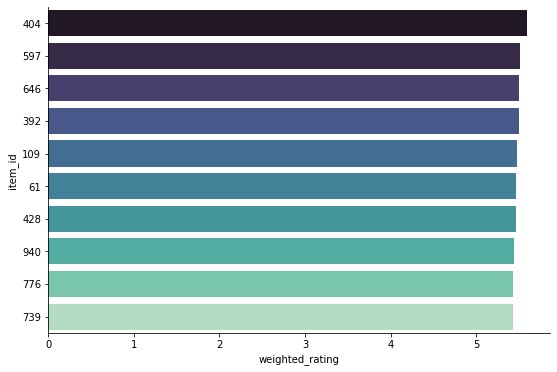

In [16]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'

pop_items = assign_popular_based_score(ratings, items, USER_COL, ITEM_COL, RATING_COL)
pop_items = pop_items.sort_values('weighted_rating', ascending = False)

fix, ax = plt.subplots(figsize=(9,6))
sns.barplot(data = pop_items.head(10),
            y = 'item_id',
            x = 'weighted_rating',
            palette = 'mako');
sns.despine();

In [17]:
pop_items.head().set_index('item_id')

,genres,vote_count,avg_rating,weighted_rating
item_id,,,,
404,Mystery,39,6.153846,5.588628
597,Mystery,42,5.976190,5.516554
646,Romance,38,6.000000,5.504268
392,"Romance, Action",45,5.911111,5.497884
109,"Fantasy, Thriller",44,5.886364,5.479565


Несмотря на то, что это достаточно простой алгоритм и он не приводит нас к персонализированным рекомендациям, он все равно очень полезен.  
За несколько строчек кода мы в базовом виде решили проблему холодного старта, которая есть в любой задаче, связанной с рекомендациями.

# 5. Content-based система

В данном типе рекомендательных систем мы даем рекомендации на основе того, что пользователю уже понравилось.  
Преимущество данного подхода в том, что мы собираемся давать намного более релевантные рекомендации, чем базовая модель.  
При этом, этот тип систем все равно уступает более совершенным моделям по простой причине: если пользователь ставил оценки только триллерам, то и рекомендации в будущем будут даваться только по триллерам. 

Как будет делаться рекомендация?  
Например, мы можем взять все действия пользователя (какие фильмы смотрел, какие оценки им ставил) и представить их в виде набора чисел – вектора.  
Точно так же, мы можем собрать информацию о каждом фильме в похожий вектор.  
Чтобы получить рекомендацию в нашем случае, нужно будет сделать следующее: 
* Собрать все векторы для пользователей и для фильмов
* Посчитать похожесть векторов всех фильмов
* Найти несколько самых похожих пар векторов и показать пользователю рекомендации по фильму, который он только что посмотрел

Похожесть векторов можно считать по-разному. Мы будем пользовать косинусной метрикой:

$$cos\_sim(x, y) = \frac{<x, y>}{||x||\cdot ||y||}$$

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def top_k_items(item_id, top_k, corr_mat, map_name):
    top_items = corr_mat[item_id, :].argsort()[-top_k:][::-1] 
    top_items = [map_name[e] for e in top_items] 

    return top_items

In [19]:
rated_items = items.loc[items[ITEM_COL].isin(ratings[ITEM_COL])].copy()

genre = rated_items['genres'].str.split(",", expand=True)

all_genre = set()
for c in genre.columns:
    distinct_genre = genre[c].str.lower().str.strip().unique()
    all_genre.update(distinct_genre)
all_genre.remove(None)

item_genre_mat = rated_items[[ITEM_COL, 'genres']].copy()
item_genre_mat['genres'] = item_genre_mat['genres'].str.lower().str.strip()

for genre in all_genre:
    item_genre_mat[genre] = np.where(item_genre_mat['genres'].str.contains(genre), 1, 0)
item_genre_mat = item_genre_mat.drop(['genres'], axis=1)
item_genre_mat = item_genre_mat.set_index(ITEM_COL)

In [20]:
item_genre_mat

,fantasy,thriller,drama,horror,mystery,romance,comedy,western,action
item_id,,,,,,,,,
0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,1,0
3,1,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,1,0
996,0,0,0,0,0,0,1,0,0
997,0,0,1,0,0,0,0,0,0


In [21]:
corr_mat = cosine_similarity(item_genre_mat)

In [22]:
corr_mat

array([[1.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.70710678, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.70710678, ..., 1.        , 0.        ,
        0.        ],
       [0.5       , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [23]:
ind2name = {ind:name for ind, name in enumerate(item_genre_mat.index)}
name2ind = {v:k for k, v in ind2name.items()}
similar_items = top_k_items(name2ind['99'],
                            top_k = 10,
                            corr_mat = corr_mat,
                            map_name = ind2name)

print("The top-k similar movie to item_id 99")
display(items.loc[items[ITEM_COL].isin(similar_items)])

The top-k similar movie to item_id 99


,item_id,genres
0,0,"Romance, Action"
99,99,"Romance, Action"
211,211,"Romance, Action"
352,352,"Romance, Action"
512,512,"Action, Romance"
618,618,"Romance, Action"
737,737,"Action, Romance"
744,744,"Romance, Action"
813,813,"Action, Romance"
858,858,"Romance, Action"


Как и ожидалось, рекомендации получились из того же жанра, что и оригинальный фильм.